# Lab 5:  Convolutional Neural Networks

## Saturday, November 10th 2018

**David Sondak and Pavlos Protopapas**

This lab will cover the following topics:

* [Intro to Convnets](#part1)
    * [The Return of MNIST](#part11)
    * [The Convolution Operation](#part12)
    * [The Max-pooling Operation](#part13)
* [Training a Convnet from Scratch on a small dataset](#part2)
    * [Using a small dataset](#part21)
    * [The relevance of deep learning for small-data problems](#part22)
    * [Data setup](#part23)
    * [Building your network](#part24)
    * [Data preprocessing](#part25)
* [Data Augmentation](#part3) 
* [References and Acknowledgements](#references)

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [2]:
%matplotlib inline

<a id='part1'></a>
## Part 1 - Intro to Convnets

<a id='part11'></a>
### 1.1 - `MNIST`
The [`MNIST` dataset](https://keras.io/datasets/#mnist-database-of-handwritten-digits) is a classical machine learning problem in classification.  The dataset contains 60000 images of handwritten digits (from 0-9).  The machine learning goal is to have an algorithm that can recognize a handwritten digits.  Using `Keras`, a simple fully-connected feedforward network can achieve a classification accuracy of approximately 97.8%.  A convolutional neural network (CNN) applied to the same dataset can increase the accuracy even more.

#### Instantiate a small convnet

The inputs to the convnet are input tensors of shape `(image_height, image_width, image_channels)` (not including the batch dimension). In this case, we’ll configure the convnet to process inputs of size `(28, 28, 1)`, which is the format of the MNIST images. We’ll do this by passing the argument `input_shape=(28, 28, 1)` to the first layer.

In [3]:
from keras import layers 
from keras import models

model = models.Sequential() # Create sequential model

# Add network layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

Using TensorFlow backend.


#### Discussion

You can see that the output of every `Conv2D` and `MaxPooling2D` layer is a 3D tensor of shape `(height, width, channels)`. The width and height dimensions tend to shrink as you go deeper in the network. The number of channels is controlled by the first argument passed to the `Conv2D` layers (32 or 64).

#### Densely connected classifier network
The next step is to feed the last output tensor (of shape `(3, 3, 64)`) into a densely connected classifier network like those you’re already familiar with: a stack of `Dense` layers. These classifiers process vectors, which are 1D, whereas the current output is a 3D tensor. First we have to flatten the 3D outputs to 1D, and then add a few `Dense` layers on top.

In [4]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                36928     
__________

As you can see, the `(3, 3, 64)` outputs are flattened into vectors of shape `(576,)` before going through two `Dense` layers.
Now, let’s train the convnet on the MNIST digits.

In [6]:
from keras.datasets import mnist
from keras.utils import to_categorical

# Load data and preprocess
(train_images, train_labels), (test_images, test_labels) = mnist.load_data() # load MNIST data

train_images = train_images.reshape((60000, 28, 28, 1)) # Reshape to get third dimension
train_images = train_images.astype('float32') / 255 # Normalize between 0 and 1

test_images = test_images.reshape((10000, 28, 28, 1)) # Reshape to get third dimension
test_images = test_images.astype('float32') / 255 # Normalize between 0 and

# Convert labels to categorical data
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

# Compile model
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fit the model
model.fit(train_images, train_labels, epochs=5, batch_size=64)

#  Evaluate the model on the test data:
test_loss, test_acc = model.evaluate(test_images, test_labels)
test_acc

Epoch 1/5
60000/60000 [==============================] - 30s 494us/step - loss: 0.1711 - acc: 0.9464
Epoch 2/5
60000/60000 [==============================] - 31s 515us/step - loss: 0.0482 - acc: 0.9851
Epoch 3/5
60000/60000 [==============================] - 30s 505us/step - loss: 0.0325 - acc: 0.9904
Epoch 4/5
60000/60000 [==============================] - 30s 498us/step - loss: 0.0251 - acc: 0.9919
Epoch 5/5
10000/10000 [==============================] - 2s 164us/step


0.9924

Whereas the densely connected network from ImageClassification had a test accuracy of 97.8%, the basic convnet has a test accuracy of 99.3%: we decreased the error rate by 68% (relative) with only 5 epochs. Not bad!
But why does this simple convnet work so well, compared to a densely connected model? To answer this, let’s dive into what the `Conv2D` and `MaxPooling2D` layers do.

<a id='part12'></a>
### 1.2 - The convolution operation

The fundamental difference between a densely connected layer and a convolution layer is this: Dense layers learn global patterns in their input feature space (for example, for an MNIST digit, patterns involving all pixels), whereas convolution layers learn local patterns: in the case of images, patterns found in small 2D windows of the inputs. In the previous example, these windows were all $3 \times 3$.

![breaking images into patterns](figs/cnn1.png)


This key characteristic gives convnets two interesting properties:
1. The patterns they learn are *translation invariant*. After learning a certain pattern in the lower-right corner of a picture, a convnet can recognize it anywhere: for example, in the upper-left corner. A densely connected network would have to learn the pattern anew if it appeared at a new location. This makes convnets data efficient when processing images (because the visual world is fundamentally translation invariant): they need fewer training samples to learn representations that have generalization power.
2. They can learn *spatial hierarchies of patterns* . A first convolution layer will learn small local patterns such as edges, a second convolution layer will learn larger patterns made of the features of the first layers, and so on. This allows convnets to efficiently learn increasingly complex and abstract visual con- cepts (because the visual world is fundamentally spatially hierarchical).

![spatial hierarchies](figs/cnn2.png)


Convolutions operate over 3D tensors, called *feature maps*, with two spatial axes (*height* and *width*) as well as a *depth* axis (also called the *channels* axis). For an RGB image, the dimension of the depth axis is 3, because the image has three color channels: red, green, and blue. For a black-and-white picture, like the MNIST digits, the depth is 1 (levels of gray). The convolution operation extracts patches from its input feature map and applies the same transformation to all of these patches, producing an *output feature map*. This output feature map is still a 3D tensor: it has a width and a height. Its depth can be arbitrary, because the output depth is a parameter of the layer, and the different channels in that depth axis no longer stand for specific colors as in RGB input; rather, they stand for *filters*. Filters encode specific aspects of the input data: at a high level, a single filter could encode the concept “presence of a face in the input,” for instance.

In the MNIST example, the first convolution layer takes a feature map of size `(28, 28, 1)` and outputs a feature map of size `(26, 26, 32)`: it computes 32 filters over its input. Each of these 32 output channels contains a $26 \times 26$ grid of values, which is a *response map* of the filter over the input, indicating the response of that filter pattern at different locations in the input. That is what the term *feature map* means: every dimension in the depth axis is a feature (or filter), and the 2D tensor `output[:, :, n]` is the 2D spatial *map* of the response of this filter over the input.

Convolutions are defined by two key parameters:
1. *Size of the patches extracted from the inputs* - These are typically $3 \times 3$ or $5 \times 5$. In the example, they were $3 \times 3$, which is a common choice.
2. *Depth of the output feature map*  - The number of filters computed by the convolution. The example started with a depth of 32 and ended with a depth of 64.

In `Keras` `Conv2D` layers, these parameters are the first arguments passed to the layer: `Conv2D(output_depth, (window_height, window_width))`.

A convolution works by *sliding* these windows of size $3 \times 3$ or $5 \times 5$ over the 3D input feature map, stopping at every possible location, and extracting the 3D patch of surrounding features (shape `(window_height, window_width, input_depth)`). Each such 3D patch is then transformed (via a tensor product with the same learned weight matrix, called the *convolution kernel* ) into a 1D vector of shape `(output_depth,)`. All of these vectors are then spatially reassembled into a 3D output map of shape `(height, width, output_depth)`. Every spatial location in the output feature map corresponds to the same location in the input feature map (for example, the lower-right corner of the output contains information about the lower-right corner of the input). For instance, with $3 \times 3$ windows, the vector `output[i, j, :]` comes from the 3D patch `input[i-1:i+1,j-1:j+1,:]`. 

<a id='part13'></a>
### 1.3 - The max-pooling operation

In the convnet example, you may have noticed that the size of the feature maps is halved after every `MaxPooling2D` layer. For instance, before the first `MaxPooling2D` layers, the feature map is $26 \times 26$, but the max-pooling operation halves it to $13 \times 13$. That’s the role of max pooling: to aggressively **downsample** feature maps, much like strided convolutions.

Max pooling consists of extracting windows from the input feature maps and outputting the max value of each channel. It’s conceptually similar to convolution, except that instead of transforming local patches via a learned linear transformation (the convolution kernel), they’re transformed via a hardcoded `max` tensor operation. A big dif- ference from convolution is that max pooling is usually done with $2 \times 2$ windows and stride 2, in order to downsample the feature maps by a factor of 2. On the other hand, convolution is typically done with $3 \times 3$ windows and no stride (stride 1).

Why downsample feature maps this way? Why not remove the max-pooling layers and keep fairly large feature maps all the way up? Let’s look at this option. The convolutional base of the model would then look like this:

In [7]:
model_no_max_pool = models.Sequential()
model_no_max_pool.add(layers.Conv2D(32, (3, 3), activation='relu',
                      input_shape=(28, 28, 1)))
model_no_max_pool.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_no_max_pool.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_no_max_pool.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 22, 22, 64)        36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


What’s wrong with this setup? Two things:
1. It isn’t conducive to learning a spatial hierarchy of features. The $3 \times 3$ windows in the third layer will only contain information coming from 7 × 7 windows in the initial input. The high-level patterns learned by the convnet will still be very small with regard to the initial input, which may not be enough to learn to classify digits (try recognizing a digit by only looking at it through windows that are 7 × 7 pixels!). We need the features from the last convolution layer to contain information about the totality of the input.
2. The final feature map has $22 \times 22 \times 64 = 30,976$ total coefficients per sample. This is huge. If you were to flatten it to stick a `Dense` layer of size 512 on top, that layer would have 15.8 million parameters. This is far too large for such a small model and would result in intense overfitting.

In short, the reason to use downsampling is to reduce the number of feature-map coefficients to process, as well as to induce spatial-filter hierarchies by making successive convolution layers look at increasingly large windows (in terms of the fraction of the original input they cover).

Note that max pooling isn’t the only way you can achieve such downsampling. You can also use strides in the prior convolution layer. And you can use average pooling instead of max pooling, where each local input patch is transformed by taking the average value of each channel over the patch, rather than the max. But max pooling tends to work better than these alternative solutions. In a nut- shell, the reason is that features tend to encode the spatial presence of some pattern or concept over the different tiles of the feature map (hence, the term *feature map*), and it’s more informative to look at the *maximal presence* of different features than at their *average presence*. So the most reasonable subsampling strategy is to first produce dense maps of features (via unstrided convolutions) and then look at the maximal activation of the features over small patches, rather than looking at sparser windows of the inputs (via strided convolutions) or averaging input patches, which could cause you to miss or dilute feature-presence information.

At this point, you should understand the basics of convnets (feature maps, convolution, and max pooling) and you know how to build a small convnet to solve a toy problem such as MNIST digits classification. Now let’s move on to more useful, practical applications.

<a id='part2'></a>
## Part 2 - Training a Convnet from Scratch on a small dataset


<a id='part21'></a>
### Part 2.1 - Using a small dataset

Having to train an image-classification model using very little data is a common situation, which you’ll likely encounter in practice if you ever do computer vision in a professional context. A "few" samples can mean anywhere from a few hundred to a few tens of thousands of images. As a practical example, we’ll focus on classifying images as dogs or cats in a dataset containing 4,000 pictures of cats and dogs (2,000 cats, 2,000 dogs). We’ll use 2,000 pictures for training: 1,000 for validation, and 1,000 for testing.

In this section, we’ll review one basic strategy to tackle this problem: training a new model from scratch using what little data you have. You’ll start by naively training a small convnet on the 2,000 training samples, without any regularization, to set a baseline for what can be achieved. This will get you to a classification accuracy of 71%. At that point, the main issue will be overfitting. Then we’ll introduce *data augmentation*, a powerful technique for mitigating overfitting in computer vision. By using data augmentation, you’ll improve the network to reach an accuracy of 82%.

<a id='part22'></a>
### Part 2.2 - The relevance of deep learning for small-data problems

You’ll sometimes hear that deep learning only works when lots of data is available. This is valid in part: one fundamental characteristic of deep learning is that it can find interesting features in the training data on its own, without any need for manual feature engineering, and this can only be achieved when lots of training examples are available. This is especially true for problems where the input samples are very high- dimensional, like images.

But what constitutes lots of samples is relative -- relative to the size and depth of the network you’re trying to train, for starters. It isn’t possible to train a convnet to solve a complex problem with just a few tens of samples, but a few hundred can potentially suffice if the model is small and well regularized and the task is simple. Because convnets learn local, translation-invariant features, they’re highly data efficient on perceptual problems. Training a convnet from scratch on a very small image dataset will still yield reasonable results despite a relative lack of data, without the need for any custom feature engineering. You’ll see this in action in this section.

What’s more, deep-learning models are by nature highly repurposable: you can take, say, an image-classification or speech-to-text model trained on a large-scale dataset and reuse it on a significantly different problem with only minor changes. Specifically, in the case of computer vision, many pretrained models (usually trained on the ImageNet dataset) are now publicly available for download and can be used to bootstrap powerful vision models out of very little data. That’s what you’ll do in the next section. Let’s start by getting your hands on the data.

<a id='part23'></a>
### Part 2.3 - Data setup


The Dogs vs. Cats dataset that you’ll use isn’t packaged with Keras. It was made available by Kaggle as part of a computer-vision competition in late 2013, back when convnets weren’t mainstream. The data has been downloaded for you from [https://www.kaggle.com/c/dogs-vs-cats/data](https://www.kaggle.com/c/dogs-vs-cats/data) 

The pictures are medium-resolution color JPEGs. Unsurprisingly, the dogs-versus-cats Kaggle competition in 2013 was won by entrants who used convnets. The best entries achieved up to 95% accuracy. In this example, you’ll get fairly close to this accuracy (in the next section), even though you’ll train your models on less than 10% of the data that was available to the competitors.

A new dataset containing three subsets has been created for you: a training set with 1,000 samples of each class, a validation set with 500 samples of each class, and a test set with 500 samples of each class.

In [8]:
# TODO: set your base dir to your correct local location
base_dir = 'cats_and_dogs_small'

import os, shutil

# Set up directory information

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

print('total training cat images:', len(os.listdir(train_cats_dir))) 
print('total training dog images:', len(os.listdir(train_dogs_dir))) 
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir))) 
print('total test dog images:', len(os.listdir(test_dogs_dir))) 


total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


So you do indeed have 2,000 training images, 1,000 validation images, and 1,000 test images. Each split contains the same number of samples from each class: this is a balanced binary-classification problem, which means classification accuracy will be an appropriate measure of success.

<a id='part24'></a>
### Part 2.4 - Building your network

You built a small convnet for MNIST in the previous example, so you should be familiar with such convnets. You’ll reuse the same general structure: the convnet will be a stack of alternated `Conv2D` (with `relu` activation) and `MaxPooling2D` layers.

But because you’re dealing with bigger images and a more complex problem, you’ll make your network larger, accordingly: it will have one more `Conv2D + MaxPooling2D` stage. This serves both to augment the capacity of the network and to further reduce the size of the feature maps so they aren’t overly large when you reach the `Flatten` layer. Here, because you start from inputs of size $150 \times 150$ (a somewhat arbitrary choice), you end up with feature maps of size $7 \times 7$ just before the Flatten layer.


**NOTE:** The depth of the feature maps progressively increases in the network (from 32 to 128), whereas the size of the feature maps decreases (from $148 \times 148$ to $7 \times 7$). This is a pattern you’ll see in almost all convnets.

Because you’re attacking a binary-classification problem, you’ll end the network with a single unit (a `Dense` layer of size 1) and a `sigmoid` activation. This unit will encode the probability that the network is looking at one class or the other.

In [9]:
from keras import layers
from keras import models
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 15, 15, 128)       147584    
__________

For the compilation step, you’ll go with the `RMSprop` optimizer. Because you ended the network with a single sigmoid unit, you’ll use `binary crossentropy` as the loss.

In [10]:
from keras import optimizers
model.compile(loss='binary_crossentropy',
                      optimizer=optimizers.RMSprop(lr=1e-4),
                      metrics=['acc'])

<a id='part25'></a>
### Part 2.5 - Data Preprocessing

As you know by now, data should be formatted into appropriately preprocessed floating-point tensors before being fed into the network. Currently, the data sits on a drive as JPEG files, so the steps for getting it into the network are roughly as follows:

1. Read the picture files.
2. Decode the JPEG content to RGB grids of pixels.
3. Convert these into floating-point tensors.
4. Rescale the pixel values (between 0 and 255) to the [0, 1] interval (as you know, neural networks prefer to deal with small input values).

It may seem a bit daunting, but fortunately Keras has utilities to take care of these steps automatically. Keras has a module with image-processing helper tools, located at `keras.preprocessing.image`. In particular, it contains the class ImageDataGenerator, which lets you quickly set up Python generators that can automatically turn image files on disk into batches of preprocessed tensors. This is what you’ll use here.


In [11]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Let’s look at the output of one of these generators: it yields batches of $150 \times 150$ RGB images (shape `(20, 150, 150, 3)`) and binary labels (shape `(20,)`). There are 20 samples in each batch (the batch size). Note that the generator yields these batches indefinitely: it loops endlessly over the images in the target folder. For this reason, you need to break the iteration loop at some point:

In [12]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


Let’s fit the model to the data using the generator. You do so using the `fit_generator` method, the equivalent of `fit` for data generators like this one. It expects as its first argument a `Python` generator that will yield batches of inputs and targets indefinitely, like this one does. Because the data is being generated endlessly, the Keras model needs to know how many samples to draw from the generator before declaring an epoch over. This is the role of the steps_per_epoch argument: after having drawn `steps_per_epoch` batches from the generator—that is, after having run for `steps_per_epoch` gradient descent steps - the fitting process will go to the next epoch. In this case, batches are 20 samples, so it will take 100 batches until you see your target of 2,000 samples.

When using `fit_generator`, you can pass a `validation_data` argument, much as with the `fit` method. It’s important to note that this argument is allowed to be a data generator, but it could also be a tuple of `Numpy` arrays. If you pass a generator as `validation_data`, then this generator is expected to yield batches of validation data endlessly; thus you should also specify the `validation_steps` argument, which tells the process how many batches to draw from the validation generator for evaluation

In [13]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=5, # TODO: should be 30
      validation_data=validation_generator,
      validation_steps=50)


# It’s good practice to always save your models after training.
model.save('cats_and_dogs_small_1.h5')

Epoch 1/5
100/100 [==============================] - 117s 1s/step - loss: 0.6870 - acc: 0.5355 - val_loss: 0.6782 - val_acc: 0.5600
Epoch 2/5
100/100 [==============================] - 101s 1s/step - loss: 0.6487 - acc: 0.6390 - val_loss: 0.6557 - val_acc: 0.5810
Epoch 3/5
100/100 [==============================] - 92s 916ms/step - loss: 0.6007 - acc: 0.6760 - val_loss: 0.6152 - val_acc: 0.6650
Epoch 4/5
100/100 [==============================] - 82s 816ms/step - loss: 0.5508 - acc: 0.7250 - val_loss: 0.6129 - val_acc: 0.6590
Epoch 5/5
100/100 [==============================] - 80s 797ms/step - loss: 0.5287 - acc: 0.7340 - val_loss: 0.5975 - val_acc: 0.6910


Let’s plot the loss and accuracy of the model over the training and validation data during training:

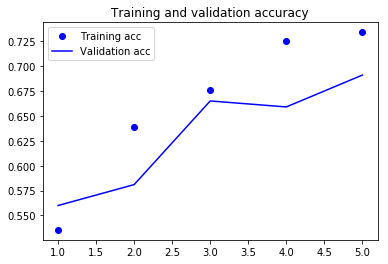

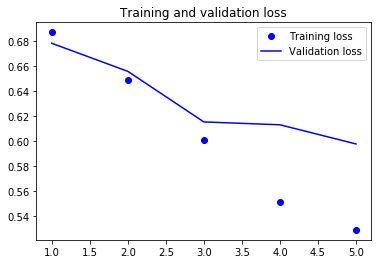

In [14]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

These plots are characteristic of overfitting. The training accuracy increases linearly, whereas the validation accuracy stalls at 70–72%. The validation loss reaches its minimum after only five epochs and then stalls, whereas the training loss keeps decreasing linearly.

Because you have relatively few training samples (2,000), overfitting will be your number-one concern. You already know about a number of techniques that can help mitigate overfitting, such as dropout and weight decay (L2 regularization). We’re now going to work with a new one, specific to computer vision and used almost universally when processing images with deep-learning models: *data augmentation*.

<a id='part3'></a>
## Part 3 - Data Augmentation

Overfitting is caused by having too few samples to learn from, rendering you unable to train a model that can generalize to new data. Given infinite data, your model would be exposed to every possible aspect of the data distribution at hand: you would never overfit. Data augmentation takes the approach of generating more training data from existing training samples, by *augmenting* the samples via a number of random transformations that yield believable-looking images. The goal is that at training time your model will never see the exact same picture twice. This helps expose the model to more aspects of the data and generalize better.

In `Keras`, this can be done by configuring a number of random transformations to be performed on the images read by the `ImageDataGenerator` instance. Let’s get started with an example.

In [15]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

These are just a few of the options available (for more, see the [`Keras` documentation](https://keras.io/preprocessing/image/)). Let’s quickly go over this code:
* `rotation_range` is a value in degrees (0–180), a range within which to randomly rotate pictures.
* `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
* `shear_range` is for randomly applying shearing transformations.
* `zoom_range` is for randomly zooming inside pictures.
* `horizontal_flip` is for randomly flipping half the images horizontally—relevant when there are no assumptions of horizontal asymmetry (for example, real-world pictures).
* `fill_mode` is the strategy used for filling in newly created pixels, which can
appear after a rotation or a width/height shift. Let’s look at the augmented images 

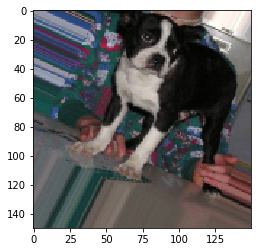

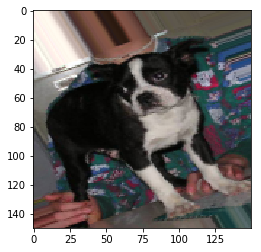

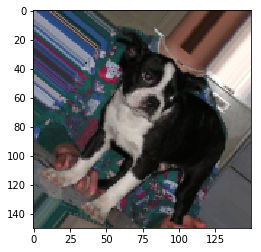

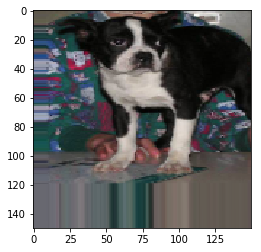

In [19]:
from keras.preprocessing import image
fnames = [os.path.join(train_dogs_dir, fname) for
     fname in os.listdir(train_dogs_dir)]
img_path = fnames[3] # Chooses one image to augment
img = image.load_img(img_path, target_size=(150, 150))
# Reads the image and resizes it
x = image.img_to_array(img) # Converts it to a Numpy array with shape (150, 150, 3) 
x = x.reshape((1,) + x.shape) # Reshapes it to (1, 150, 150, 3)
i=0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

If you train a new network using this data-augmentation configuration, the network will never see the same input twice. But the inputs it sees are still heavily intercorrelated, because they come from a small number of original images—you can’t produce new information, you can only remix existing information. As such, this may not be enough to completely get rid of overfitting. To further fight overfitting, you’ll also add a `Dropout` layer to your model right before the densely connected classifier.

In [20]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [21]:
# Let’s train the network using data augmentation and dropout.

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)
test_datagen = ImageDataGenerator(rescale=1./255)
# Note that the validation data shouldn’t be augmented!

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=5, # TODO: should be 100
      validation_data=validation_generator,
      validation_steps=50)

model.save('cats_and_dogs_small_2.h5')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/5
100/100 [==============================] - 135s 1s/step - loss: 0.6933 - acc: 0.5056 - val_loss: 0.6844 - val_acc: 0.5692
Epoch 2/5
100/100 [==============================] - 128s 1s/step - loss: 0.6788 - acc: 0.5672 - val_loss: 0.6563 - val_acc: 0.6028
Epoch 3/5
100/100 [==============================] - 127s 1s/step - loss: 0.6706 - acc: 0.5822 - val_loss: 0.6413 - val_acc: 0.6282
Epoch 4/5
100/100 [==============================] - 126s 1s/step - loss: 0.6604 - acc: 0.6053 - val_loss: 0.6331 - val_acc: 0.6212
Epoch 5/5
100/100 [==============================] - 129s 1s/step - loss: 0.6399 - acc: 0.6197 - val_loss: 0.6923 - val_acc: 0.5749


And let’s plot the results again. Thanks to data augmentation and dropout, you’re no longer overfitting: the training curves are closely tracking the validation curves. You now reach an accuracy of 82%, a 15% relative improvement over the non-regularized model.

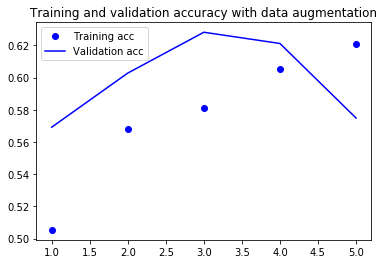

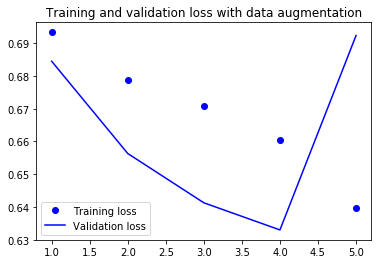

In [22]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy with data augmentation')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss with data augmentation')
plt.legend()
plt.show()


By using regularization techniques even further, and by tuning the network’s parameters (such as the number of filters per convolution layer, or the number of layers in the network), you may be able to get an even better accuracy, likely up to 86% or 87%. But it would prove difficult to go any higher just by training your own convnet from scratch, because you have so little data to work with. As a next step to improve your accuracy on this problem, you’ll have to use a pretrained model.

<a id='references'></a>
### References and Acknowledgements

* Most of this lab is based on the book [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python), Chapter 5 written by the Francois Chollet, the author of Keras. It is a very practical introduction to Deep Learning. It is appropriate for those with some Python knowledge who want to start with machine learning.